# CIS 5450 Final Project

Dataset: https://www.kaggle.com/datasets/tsaustin/us-historical-stock-prices-with-earnings-data

In [151]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [152]:
# Load datasets
prices = pd.read_csv(
    "./datasets/stock_prices_latest.csv",
    parse_dates=["date"],
    dtype={"symbol": str}
)
earnings = pd.read_csv(
    "./datasets/earnings_latest.csv",
    parse_dates=["date"],
    dtype={"symbol": str, "announce_time": str}
)

In [153]:
display(earnings.columns)
display(prices.columns)

Index(['symbol', 'date', 'qtr', 'eps_est', 'eps', 'release_time'], dtype='object')

Index(['symbol', 'date', 'open', 'high', 'low', 'close', 'close_adjusted',
       'volume', 'split_coefficient'],
      dtype='object')

# Cleaning Dataset

In [154]:
# Rename Columns
earnings = earnings.rename(
    columns={
        "date": "earnings_date",
        "eps_est": "consensus_eps",
        "eps": "actual_eps",
        "release_time": "announce_time"
    }
)
display(earnings.columns)

Index(['symbol', 'earnings_date', 'qtr', 'consensus_eps', 'actual_eps',
       'announce_time'],
      dtype='object')

In [155]:
# Drop events missing EPS or announcement time
earnings = earnings.dropna(
    subset=["consensus_eps", "actual_eps", "announce_time"]
).reset_index(drop=True)

# Compute the effective trading date of the event
def effective_trade_date(row):
    # After Market Close (AMC) → next trading day; Before Market Open (BMO) → same day
    if row["announce_time"].upper().startswith("AMC"):
        return row["earnings_date"] + pd.Timedelta(days=1)
    else:
        return row["earnings_date"]

earnings["trade_date"] = earnings.apply(effective_trade_date, axis=1)

In [156]:
# Restrict price data to the relevant date span (±5 days around events)
min_date = earnings["trade_date"].min() - pd.Timedelta(days=5)
max_date = earnings["trade_date"].max() + pd.Timedelta(days=5)
prices = prices[
    (prices["date"] >= min_date) &
    (prices["date"] <= max_date)
].copy()

# Keep only adjusted prices to handle splits/dividends
prices = prices[[
    "symbol", "date", "close_adjusted", "open", "high", "low", "volume"
]]

# Merge earnings events with price data on effective trade date
event_prices = pd.merge(
    earnings[["symbol", "earnings_date", "trade_date", "actual_eps", "consensus_eps", "announce_time"]],
    prices,
    left_on=["symbol", "trade_date"],
    right_on=["symbol", "date"],
    how="inner"
)

# Drop duplicates and reset index
event_prices = event_prices.drop_duplicates(subset=["symbol", "earnings_date"]).reset_index(drop=True)

# Save cleaned data for downstream analysis
event_prices.to_csv("cleaned_event_price_data.csv", index=False)

# Display the shape of the cleaned dataset
event_prices.shape

(79444, 12)

# EDA

In [7]:
df = pd.read_csv("cleaned_event_price_data.csv", parse_dates=["earnings_date", "trade_date", "date"])

# Compute earnings surprise and event-day return
df['surprise'] = df['actual_eps'] - df['consensus_eps']
df['return'] = (df['close_adjusted'] - df['open']) / df['open']

# Create a binary indicator for beat vs. miss
df['beat'] = df['surprise'] > 0

# Extract the year of each earnings date
df['year'] = df['earnings_date'].dt.year

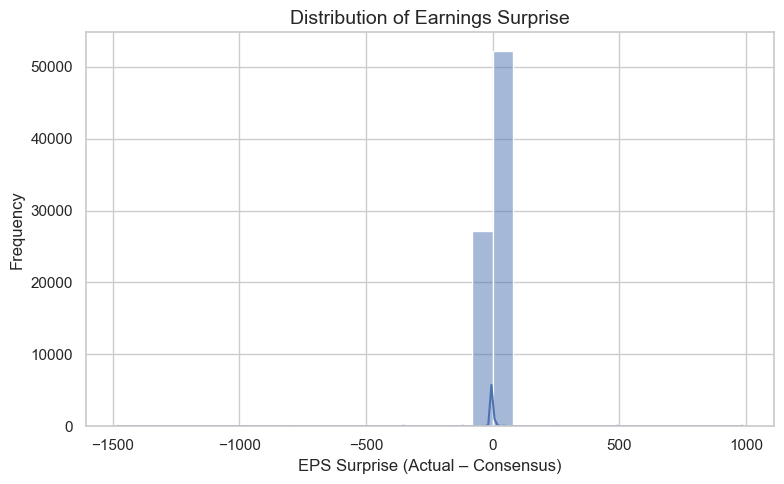

In [8]:
# Set Seaborn style
sns.set(style="whitegrid")

# 1. Distribution of Earnings Surprise
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='surprise', bins=30, kde=True)
plt.title("Distribution of Earnings Surprise", fontsize=14)
plt.xlabel("EPS Surprise (Actual – Consensus)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

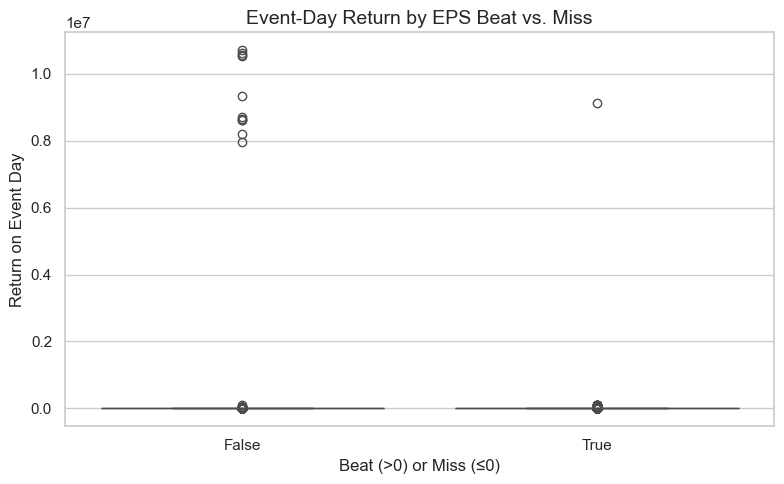

In [9]:
# 2. Boxplot: Event-Day Return by Beat vs. Miss
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='beat', y='return')
plt.title("Event-Day Return by EPS Beat vs. Miss", fontsize=14)
plt.xlabel("Beat (>0) or Miss (≤0)")
plt.ylabel("Return on Event Day")
plt.tight_layout()
plt.show()

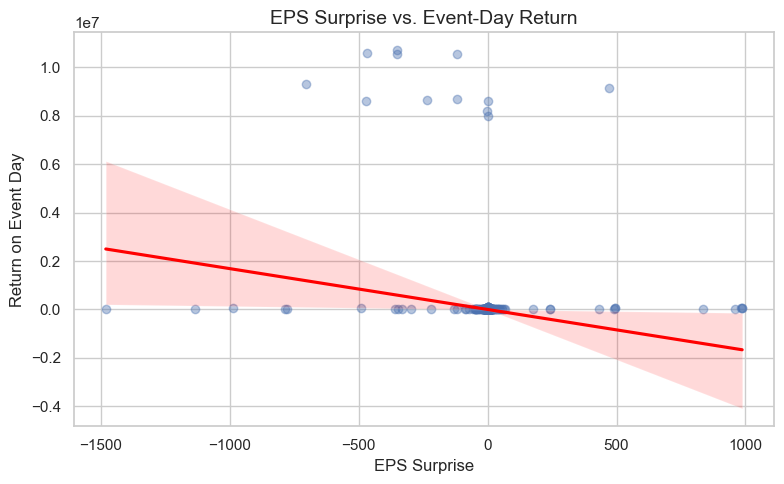

In [10]:
# 3. Scatter with Regression: Surprise vs. Event-Day Return
plt.figure(figsize=(8, 5))
sns.regplot(data=df, x='surprise', y='return', scatter_kws={'alpha':0.4}, line_kws={'color':'red'})
plt.title("EPS Surprise vs. Event-Day Return", fontsize=14)
plt.xlabel("EPS Surprise")
plt.ylabel("Return on Event Day")
plt.tight_layout()
plt.show()


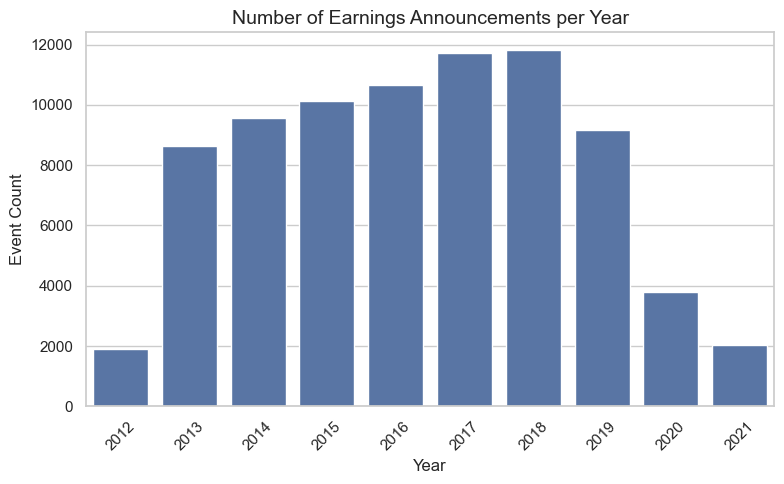

In [11]:
# 4. Count of Earnings Events per Year
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df, x='year')
plt.title("Number of Earnings Announcements per Year", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Event Count")
# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Models - Baselines

### Always Predict 

In [105]:
from imblearn.combine import SMOTETomek
smt = SMOTETomek(random_state=42)

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, confusion_matrix,
    mean_squared_error, mean_absolute_error, classification_report, roc_auc_score
)

In [108]:
df = pd.read_csv(
    "cleaned_event_price_data.csv",
    parse_dates=["earnings_date", "trade_date", "date"]
)

# Compute the intraday event‑day return
df["return"] = (df["close_adjusted"] - df["open"]) / df["open"]

df['target_up'] = df['return'] > 0

In [109]:
# --- Classification Baseline ---
# Majority class prediction
majority_class = df['target_up'].mode()[0]
baseline_clf_preds = np.full(len(df), fill_value=majority_class)

# Metrics
acc = accuracy_score(df['target_up'], baseline_clf_preds)
prec = precision_score(df['target_up'], baseline_clf_preds)
rec = recall_score(df['target_up'], baseline_clf_preds)
cm = confusion_matrix(df['target_up'], baseline_clf_preds)

print("Classification Baseline (Always predict {})".format(
    "Up" if majority_class else "Down"
))
print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print("Confusion Matrix:\n", cm)


Classification Baseline (Always predict Down)
Accuracy: 0.660
Precision: 0.000
Recall: 0.000
Confusion Matrix:
 [[52397     0]
 [27047     0]]


/opt/anaconda3/envs/cis5450/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [110]:
# --- Regression Baseline ---
# Always predict zero return
y_true = df['return'].values
baseline_reg_preds = np.zeros_like(y_true)

mse = mean_squared_error(y_true, baseline_reg_preds)
mae = mean_absolute_error(y_true, baseline_reg_preds)

print("\nRegression Baseline (Always predict 0 return)")
print(f"Mean Squared Error: {mse:.6f}")
print(f"Mean Absolute Error: {mae:.6f}")


Regression Baseline (Always predict 0 return)
Mean Squared Error: 13221639038.342815
Mean Absolute Error: 1425.989777


# Feature Engineering

In [126]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, classification_report,
    precision_recall_curve
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [161]:
# Load cleaned event-price data
df = pd.read_csv(
    "cleaned_event_price_data.csv",
    parse_dates=["earnings_date", "trade_date", "date"]
)
display(df.columns)

Index(['symbol', 'earnings_date', 'trade_date', 'actual_eps', 'consensus_eps',
       'announce_time', 'date', 'close_adjusted', 'open', 'high', 'low',
       'volume'],
      dtype='object')

In [158]:
display(df.head(10))

,symbol,earnings_date,trade_date,actual_eps,consensus_eps,announce_time,date,close_adjusted,open,high,low,volume
0,A,2012-11-19,2012-11-19,0.84,0.80,post,2012-11-19,25.6850,37.01,37.98,37.010,5121200
1,A,2013-02-14,2013-02-14,0.63,0.66,post,2013-02-14,30.6013,44.72,44.78,44.360,3845700
2,A,2013-05-14,2013-05-14,0.77,0.67,post,2013-05-14,30.2688,42.98,44.06,42.882,6082700
3,A,2013-08-14,2013-08-14,0.68,0.62,post,2013-08-14,32.1072,46.77,47.00,46.370,1987500
4,A,2013-11-14,2013-11-14,0.81,0.76,post,2013-11-14,34.9703,51.20,51.20,50.360,2834900
5,A,2014-02-13,2014-02-13,0.67,0.66,post,2014-02-13,41.6674,59.45,60.38,59.370,3092700
6,A,2014-08-14,2014-08-14,0.78,0.74,post,2014-08-14,38.7546,54.78,55.63,54.450,3478500
7,A,2014-11-17,2014-11-17,0.88,0.50,post,2014-11-17,39.9097,41.57,41.70,41.210,2697114
8,A,2015-02-17,2015-02-17,0.41,0.41,post,2015-02-17,39.3096,40.01,40.53,39.760,2874488
9,A,2015-05-18,2015-05-18,0.38,0.39,post,2015-05-18,41.4572,42.05,42.70,41.980,1965122


In [162]:
# Feature engineering
# EPS Suprise
df["surprise"] = df["actual_eps"] - df["consensus_eps"]

# Log volume
df["log_volume"] = np.log1p(df["volume"])

# Event-day return
df["return"] = (df["close_adjusted"] - df["open"]) / df["open"]

# Create target variable: 1 if return > 0, else 0
df["target_up"] = (df["return"] > 0).astype(int)


# Market-Adjusted (Abnormal) Return
spy = pd.read_csv(
    "./SPY_prices.csv",
    parse_dates=["date"]
)
spy = spy.rename(columns={"date": "spy_date"})
spy = spy.rename(columns={"Open":"spy_open","Close":"spy_close"})
df = df.merge(spy[["spy_date","spy_open","spy_close"]], left_on="trade_date", right_on="spy_date", how="left")
df["spy_ret"] = (df["spy_close"] - df["spy_open"]) / df["spy_open"]
df["abnormal_ret"] = df["return"] - df["spy_ret"]

# Pre-Announcement Momentum
df = df.sort_values(["symbol","date"])
df["mom_5d"] = df.groupby("symbol")["close_adjusted"].pct_change(periods=5)

# Volatility
df["daily_ret"] = df.groupby("symbol")["close_adjusted"].pct_change()
df["vol_20d"] = (
    df.groupby("symbol")["daily_ret"]
      .rolling(20, min_periods=5)
      .std()
      .reset_index(level=0, drop=True)
)

# Load sector lookup
sectors = pd.read_csv("constituents.csv", usecols=["Symbol","GICS Sector"])
sectors = sectors.rename(columns={"Symbol":"symbol","GICS Sector":"sector"})

# Merge on ticker
df = df.merge(sectors, on="symbol", how="left")
sector_dummies = pd.get_dummies(df["sector"], prefix="sect")
df = pd.concat([df, sector_dummies], axis=1)

In [163]:
display(df.columns)

Index(['symbol', 'earnings_date', 'trade_date', 'actual_eps', 'consensus_eps',
       'announce_time', 'date', 'close_adjusted', 'open', 'high', 'low',
       'volume', 'surprise', 'log_volume', 'return', 'target_up', 'spy_date',
       'spy_open', 'spy_close', 'spy_ret', 'abnormal_ret', 'mom_5d',
       'daily_ret', 'vol_20d', 'sector', 'sect_Communication Services',
       'sect_Consumer Discretionary', 'sect_Consumer Staples', 'sect_Energy',
       'sect_Financials', 'sect_Health Care', 'sect_Industrials',
       'sect_Information Technology', 'sect_Materials', 'sect_Real Estate',
       'sect_Utilities'],
      dtype='object')

In [175]:
# --- 2. Event Timing Flag ---
# release_time already loaded as "announce_time", with values like "BMO"/"AMC"
# Create a binary feature: 1 if After Market Close, 0 if Before Market Open
df["after_market"] = df["announce_time"].str.upper().str.startswith("PRE").astype(int)

In [ ]:
# --- 3. Consensus EPS Revision (1-month) ---
# Requires a DataFrame `eps_history` with columns ["symbol","earnings_date","consensus_eps"]
# assumed sorted by date
# Compute prior consensus one month (30 days) before each event:
eps_history = df[["symbol","earnings_date","consensus_eps"]].drop_duplicates().sort_values(["symbol","earnings_date"])
eps_history["prior_date"] = eps_history["earnings_date"] - pd.Timedelta(days=30)
# Merge to find the last consensus before prior_date
eps_history = eps_history.merge(
    eps_history[["symbol","earnings_date","consensus_eps"]]
      .rename(columns={"earnings_date":"match_date","consensus_eps":"prior_eps"}),
    left_on=["symbol","prior_date"],
    right_on=["symbol","match_date"],
    how="left"
)
# Forward‐fill within each symbol to carry the last known consensus
eps_history = eps_history.groupby("symbol").apply(
    lambda g: g.sort_values("match_date").ffill()
).reset_index(drop=True)
# Calculate revision (% change)
eps_history["eps_rev_1m"] = (eps_history["consensus_eps"] - eps_history["prior_eps"]) / eps_history["prior_eps"]
# Merge back into main df
df = df.merge(
    eps_history[["symbol","earnings_date","eps_rev_1m"]],
    on=["symbol","earnings_date"],
    how="left"
)
# Fill missing revisions with 0 (no change)
df["eps_rev_1m"] = df["eps_rev_1m"].fillna(0)

/var/folders/p1/hw7j77550kb0wyck0r6489lm0000gn/T/ipykernel_76554/2205344493.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eps_history = eps_history.groupby("symbol").apply(


In [124]:
# Drop rows with missing values
df_model = df.dropna(subset=["surprise", "log_volume", "target_up","mom_5d", "vol_20d", "abnormal_ret"])

# Prepare predictors & target
X = df_model[["surprise", "log_volume", "mom_5d", "vol_20d", "abnormal_ret",]]
y = df_model["target_up"]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Logistic Regression

In [127]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit logistic regression
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression

# 3. Hyperparameter Search (after scaling, before fitting final model)
param_grid = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l2", "l1"],
    "solver": ["liblinear"]  # 'liblinear' supports L1 penalty
}

# Use time-series split or stratified k-fold
tscv = TimeSeriesSplit(n_splits=5)
grid = GridSearchCV(
    LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42),
    param_grid,
    cv=tscv,
    scoring="balanced_accuracy",
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_scaled, y_train)
print("Best params:", grid.best_params_)
print("Best CV balanced accuracy:", grid.best_score_)

# 4. Re-fit the model with best parameters
best_lr = grid.best_estimator_

# Predictions & evaluation
y_pred = best_lr.predict(X_test_scaled)
y_proba = best_lr.predict_proba(X_test_scaled)[:, 1]

# 7. Threshold tuning via precision–recall
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_idx = np.nanargmax(f1_scores)
best_thresh = thresholds[best_idx]

# 8. Final predictions with tuned threshold
y_pred = (y_proba >= best_thresh).astype(int)

# 9. Evaluate

print("Logistic Regression Classification Metrics:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall:    {recall_score(y_test, y_pred):.3f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_proba):.3f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Down", "Up"]))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/opt/anaconda3/envs/cis5450/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/cis5450/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/cis5450/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best params: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Best CV balanced accuracy: 0.5498375645541133
Logistic Regression Classification Metrics:
Accuracy:  0.409
Precision: 0.371
Recall:    0.935
ROC AUC:   0.579

Confusion Matrix:
[[ 892 6714]
 [ 276 3954]]

Classification Report:
              precision    recall  f1-score   support

        Down       0.76      0.12      0.20      7606
          Up       0.37      0.93      0.53      4230

    accuracy                           0.41     11836
   macro avg       0.57      0.53      0.37     11836
weighted avg       0.62      0.41      0.32     11836



/opt/anaconda3/envs/cis5450/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best threshold by F1: 0.48 F1: 0.528915127277344
Best threshold by Balanced Accuracy: 0.5 Balanced Acc: 0.5577246158159324


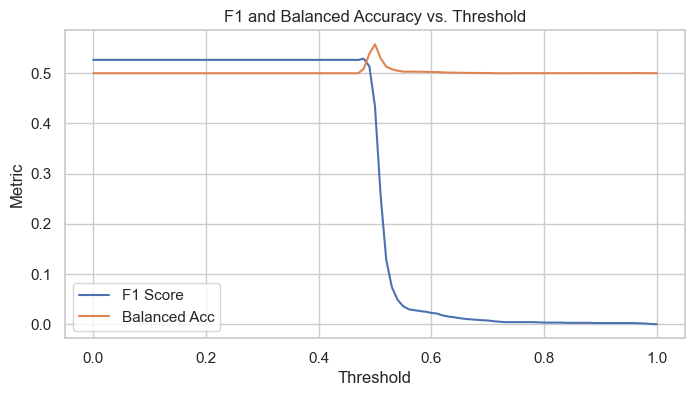


Evaluation at optimal threshold = 0.50
Balanced Accuracy: 0.5577246158159324
Classification Report:
               precision    recall  f1-score   support

        Down       0.68      0.68      0.68      7606
          Up       0.43      0.44      0.43      4230

    accuracy                           0.59     11836
   macro avg       0.56      0.56      0.56     11836
weighted avg       0.59      0.59      0.59     11836

Confusion Matrix:
 [[5163 2443]
 [2383 1847]]


In [128]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, balanced_accuracy_score
# Assume lr_clf and X_test_scaled, y_test are defined from previous cells

# 1. Assume y_proba is already computed
# y_proba = lr_clf.predict_proba(X_test_scaled)[:, 1]

# 2. Define candidate thresholds
thresholds = np.linspace(0.0, 1.0, 101)

# 3. Evaluate metrics at each threshold
results = []
for thr in thresholds:
    y_pred_thr = (y_proba >= thr).astype(int)
    f1 = f1_score(y_test, y_pred_thr)
    bal_acc = balanced_accuracy_score(y_test, y_pred_thr)
    results.append({"threshold": thr, "f1": f1, "balanced_accuracy": bal_acc})

results_df = pd.DataFrame(results)

# 4. Find best threshold by F1 and by balanced accuracy
best_f1 = results_df.loc[results_df["f1"].idxmax()]
best_bal = results_df.loc[results_df["balanced_accuracy"].idxmax()]

print("Best threshold by F1:", best_f1["threshold"], "F1:", best_f1["f1"])
print("Best threshold by Balanced Accuracy:", best_bal["threshold"], 
      "Balanced Acc:", best_bal["balanced_accuracy"])

# 5. Plot metrics vs. threshold
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(results_df["threshold"], results_df["f1"], label="F1 Score")
plt.plot(results_df["threshold"], results_df["balanced_accuracy"], label="Balanced Acc")
plt.xlabel("Threshold")
plt.ylabel("Metric")
plt.title("F1 and Balanced Accuracy vs. Threshold")
plt.legend()
plt.show()

# 6. Apply the chosen threshold (e.g., best_bal threshold)
opt_thr = best_bal["threshold"]
y_pred_opt = (y_proba >= opt_thr).astype(int)

# 7. Final evaluation
from sklearn.metrics import classification_report, confusion_matrix
print(f"\nEvaluation at optimal threshold = {opt_thr:.2f}")
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_opt))
print("Classification Report:\n", classification_report(y_test, y_pred_opt, target_names=["Down","Up"]))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_opt))

# Linear Regression

In [129]:
# --- Fit Linear Regression ---
lr = LinearRegression()
lr.fit(X_train, y_train)

# --- Predictions and Evaluation ---
y_pred = lr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Linear Regression Performance:")
print(f"  • MSE: {mse:.6f}")
print(f"  • R²:  {r2:.3f}")

Linear Regression Performance:
  • MSE: 0.229018
  • R²:  0.003


In [130]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# 1a. Scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 1b. Hyperparameter tune alpha
param_grid = {"alpha": [0.01, 0.1, 1, 10, 100]}
ridge = Ridge(random_state=42)
grid_ridge = GridSearchCV(ridge, param_grid, cv=5, scoring="neg_mean_squared_error")
grid_ridge.fit(X_train_scaled, y_train)

best_ridge = grid_ridge.best_estimator_
y_pred_ridge = best_ridge.predict(X_test_scaled)

print("Ridge Regression α:", grid_ridge.best_params_["alpha"])
print("Ridge MSE:", mean_squared_error(y_test, y_pred_ridge))
print("Ridge R²:", r2_score(y_test, y_pred_ridge))


Ridge Regression α: 100
Ridge MSE: 0.22901781388028283
Ridge R²: 0.0027994961533397422


In [131]:
from sklearn.linear_model import Lasso

param_grid = {"alpha": [0.001, 0.01, 0.1, 1]}
lasso = Lasso(random_state=42, max_iter=5000)
grid_lasso = GridSearchCV(lasso, param_grid, cv=5, scoring="neg_mean_squared_error")
grid_lasso.fit(X_train_scaled, y_train)

best_lasso = grid_lasso.best_estimator_
y_pred_lasso = best_lasso.predict(X_test_scaled)

print("Lasso Regression α:", grid_lasso.best_params_["alpha"])
print("Lasso MSE:", mean_squared_error(y_test, y_pred_lasso))
print("Lasso R²:", r2_score(y_test, y_pred_lasso))


Lasso Regression α: 0.001
Lasso MSE: 0.22901149974815832
Lasso R²: 0.002826989454534301


In [132]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly  = poly.transform(X_test_scaled)

lr_poly = Ridge(alpha=1.0, random_state=42)
lr_poly.fit(X_train_poly, y_train)
y_pred_poly = lr_poly.predict(X_test_poly)

print("Polynomial Ridge MSE:", mean_squared_error(y_test, y_pred_poly))
print("Polynomial Ridge R²:", r2_score(y_test, y_pred_poly))

Polynomial Ridge MSE: 0.2277107338100762
Polynomial Ridge R²: 0.008490847766971621


In [134]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

tscv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(best_ridge, X_train_scaled, y_train,
                         cv=tscv, scoring="r2")
print("TimeSeries R² CV scores:", scores)
print("Mean R² CV:", scores.mean())

TimeSeries R² CV scores: [0.00210045 0.00175552 0.00119333 0.00381216 0.00266843]
Mean R² CV: 0.0023059774995827674


In [133]:
# --- Model Coefficients ---
coeff_df = pd.DataFrame({
    "feature": X.columns,
    "coefficient": lr.coef_
})
coeff_df["intercept"] = lr.intercept_
display(coeff_df)

,feature,coefficient,intercept
0,surprise,1.111373e-04,0.40958
1,log_volume,-4.627554e-03,0.40958
2,mom_5d,3.184442e-03,0.40958
3,vol_20d,4.473279e-02,0.40958
4,abnormal_ret,6.969967e-08,0.40958


# Random Forest

In [137]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, train_test_split
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, classification_report, confusion_matrix

In [ ]:
# Drop rows with missing values
df_model = df.dropna(subset=["surprise", "log_volume", "target_up","mom_5d", "vol_20d",])

# Prepare predictors & target
X = df_model[["surprise", "log_volume", "mom_5d", "vol_20d",]]
y = df_model["target_up"]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [142]:

# 5. Define model and hyperparameter space
rf = RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1)

param_dist = {
    "n_estimators": [100, 200, 500],
    "max_depth": [3, 5, 10, None],
    "min_samples_leaf": [1, 5, 10],
    "max_features": ["sqrt", "log2"]
}

# 6. TimeSeriesSplit for CV
tscv = TimeSeriesSplit(n_splits=5)

search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=20,
    cv=tscv,
    scoring="balanced_accuracy",
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# 7. Fit
search.fit(X_train, y_train)
best_rf = search.best_estimator_
print("Best RF params:", search.best_params_)

# 8. Evaluate on test set
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]
y_pred_rf = best_rf.predict(X_test)

print("Random Forest Test ROC AUC:", roc_auc_score(y_test, y_proba_rf))
print("Random Forest Test Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf, target_names=["Down","Up"]))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

feat_names = X_train.columns  # capture feature names from your DataFrame
importances = pd.Series(best_rf.feature_importances_, index=feat_names).sort_values(ascending=False)
print("\nFeature Importances:\n", importances)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RF params: {'n_estimators': 100, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 5}
Random Forest Test ROC AUC: 0.9821338634610352
Random Forest Test Balanced Accuracy: 0.9383951577359917

Classification Report:
               precision    recall  f1-score   support

        Down       0.97      0.94      0.95      7606
          Up       0.89      0.94      0.92      4230

    accuracy                           0.94     11836
   macro avg       0.93      0.94      0.93     11836
weighted avg       0.94      0.94      0.94     11836

Confusion Matrix:
 [[7113  493]
 [ 247 3983]]

Feature Importances:
 abnormal_ret    0.970698
vol_20d         0.022379
mom_5d          0.003035
surprise        0.002400
log_volume      0.001489
dtype: float64


In [ ]:
feat_names = X_train.columns  # capture feature names from your DataFrame
importances = pd.Series(best_rf.feature_importances_, index=feat_names).sort_values(ascending=False)
print("\nFeature Importances:\n", importances)


Feature Importances:
 abnormal_ret    0.970698
vol_20d         0.022379
mom_5d          0.003035
surprise        0.002400
log_volume      0.001489
dtype: float64


In [176]:
# Drop rows with missing values
df_model = df.dropna(subset=["surprise", "log_volume", "target_up","mom_5d", "vol_20d", 'sect_Communication Services',
       'sect_Consumer Discretionary', 'sect_Consumer Staples', 'sect_Energy',
       'sect_Financials', 'sect_Health Care', 'sect_Industrials',
       'sect_Information Technology', 'sect_Materials', 'sect_Real Estate',
       'sect_Utilities', 'after_market', 'eps_rev_1m'])

# Prepare predictors & target
X = df_model[["surprise", "log_volume", "mom_5d", "vol_20d", 'sect_Communication Services',
       'sect_Consumer Discretionary', 'sect_Consumer Staples', 'sect_Energy',
       'sect_Financials', 'sect_Health Care', 'sect_Industrials',
       'sect_Information Technology', 'sect_Materials', 'sect_Real Estate',
       'sect_Utilities', 'after_market', 'eps_rev_1m']]
y = df_model["target_up"]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [178]:

# 5. Define model and hyperparameter space
rf = RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1)

param_dist = {
    "n_estimators": [100, 200, 500],
    "max_depth": [3, 5, 10, None],
    "min_samples_leaf": [1, 5, 10],
    "max_features": ["sqrt", "log2"]
}

# 6. TimeSeriesSplit for CV
tscv = TimeSeriesSplit(n_splits=5)

search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=20,
    cv=tscv,
    scoring="balanced_accuracy",
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# 7. Fit
search.fit(X_train, y_train)
best_rf = search.best_estimator_
print("Best RF params:", search.best_params_)

# 8. Evaluate on test set
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]
y_pred_rf = best_rf.predict(X_test)

print("Random Forest Test ROC AUC:", roc_auc_score(y_test, y_proba_rf))
print("Random Forest Test Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf, target_names=["Down","Up"]))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

feat_names = X_train.columns  # capture feature names from your DataFrame
importances = pd.Series(best_rf.feature_importances_, index=feat_names).sort_values(ascending=False)
display(importances)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/anaconda3/envs/cis5450/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best RF params: {'n_estimators': 200, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 10}
Random Forest Test ROC AUC: 0.6239586732882898
Random Forest Test Balanced Accuracy: 0.5907224854833406

Classification Report:
               precision    recall  f1-score   support

        Down       0.74      0.52      0.61      7606
          Up       0.43      0.67      0.53      4230

    accuracy                           0.57     11836
   macro avg       0.58      0.59      0.57     11836
weighted avg       0.63      0.57      0.58     11836

Confusion Matrix:
 [[3919 3687]
 [1412 2818]]


vol_20d                        0.503948
mom_5d                         0.159633
surprise                       0.141845
log_volume                     0.111996
after_market                   0.016073
sect_Financials                0.013770
sect_Utilities                 0.010511
sect_Real Estate               0.007438
sect_Energy                    0.006448
sect_Information Technology    0.005459
sect_Health Care               0.005218
sect_Materials                 0.004328
sect_Industrials               0.003846
sect_Consumer Staples          0.003789
sect_Consumer Discretionary    0.003225
sect_Communication Services    0.002289
eps_rev_1m                     0.000183
dtype: float64

# XGBoost

In [179]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, classification_report, confusion_matrix

In [188]:
# 5. Define XGBoost classifier and parameter distribution
xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",
    scale_pos_weight=(len(y_train) - y_train.sum()) / y_train.sum(),
    eval_metric="logloss",
    random_state=42,
    n_jobs=2
)

param_dist = {
    "n_estimators": [100, 200, 500],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

# 6. Time-series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

search_xgb = RandomizedSearchCV(
    xgb_clf,
    param_distributions=param_dist,
    n_iter=10,
    cv=tscv,
    scoring="balanced_accuracy",
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# 7. Fit
search_xgb.fit(X_train, y_train)
best_xgb = search_xgb.best_estimator_
print("Best XGB params:", search_xgb.best_params_)

# 8. Evaluate on the test set
y_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]
y_pred_xgb = best_xgb.predict(X_test)

print("XGBoost Test ROC AUC:", roc_auc_score(y_test, y_proba_xgb))
print("XGBoost Test Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb, target_names=["Down","Up"]))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

# 9. Feature importances
importances = pd.Series(best_xgb.feature_importances_, index=["surprise", "log_volume", "mom_5d", "vol_20d", 'sect_Communication Services',
       'sect_Consumer Discretionary', 'sect_Consumer Staples', 'sect_Energy',
       'sect_Financials', 'sect_Health Care', 'sect_Industrials',
       'sect_Information Technology', 'sect_Materials', 'sect_Real Estate',
       'sect_Utilities', 'after_market', 'eps_rev_1m']).sort_values(ascending=False)
print("\nFeature Importances:\n", importances)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best XGB params: {'subsample': 0.6, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
XGBoost Test ROC AUC: 0.6208868946936877
XGBoost Test Balanced Accuracy: 0.5877516443718378

Classification Report:
               precision    recall  f1-score   support

        Down       0.73      0.51      0.60      7606
          Up       0.43      0.67      0.52      4230

    accuracy                           0.57     11836
   macro avg       0.58      0.59      0.56     11836
weighted avg       0.62      0.57      0.57     11836

Confusion Matrix:
 [[3881 3725]
 [1416 2814]]

Feature Importances:
 vol_20d                        0.304426
mom_5d                         0.081626
surprise                       0.072273
sect_Real Estate               0.067643
sect_Utilities                 0.060361
sect_Financials                0.053706
after_market                   0.049849
sect_Information Technolo